In [1]:
from ensembles import VanillaEnsemble
from datasets import make_dataset, make_cross_validation_dataset
from plot import plot_dataset, plot_prediction
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 4]
from evaluation import evaluate_model
import tensorflow as tf

# Explanation



Showing the efficiency of two estimators, comparing to a vanialla Neural Network.

All Estimators are built in tensorflow (1.4) and are based on the same parent object (ToDo: Make this more beautiful and readable)

GaussianLossEstimator [1], in which $\mu$ and $\sigma^2$ are estimated directly by using a gaussian cost function $-1/2 ln [\sigma^2(x_i)] - \frac{[y-\hat{y}]^2}{2\sigma^2(x_i)} $. In practice, this means separate output nodes have been added for both mean and variance, with corrensponding final layers. To ensure positive $\sigma^2$, a softmax function is applied according to [2]. 

GaussianLearningRateEstimator, which is a GaussianLossEstimator in which the predicted $\sigma^2$ is used to scale the learning rate for each sample. This approach hasn't been found in a [arguable somewhat shallow] literature review. It's too early to claim novelty, but it is fun to work with!


No Regularisation has been added, thus quite a bit of overfitting occurs.







# Parameters
parameters have been chosen at 'random', i.e. not much thought has been put into them. No Gridsearch for optimal parameter spaces or similar.

each neural network is contains three hidden layers with 10 neurons each, the learning rate has been set to 0.001 which seems a literature standard (cite needed)

The layers are instantiated by draws from a normal distribution (0,1), so no distribution over parameters


# Dataset 
The Dataset contains 100 samples generated by the function 

$5 \cdot sin(X) + 10 + X^2 + noise$

where X is linearly spaced patches in the intervall [-5,5] the noise is drawn from a normal distribution (0,4)

# Training
Each network is trained on 10 * 100 = 1000 epochs

Training is on-line, i.e. each sample is fed into the network on a singular basis (Stochastic gradient descent with batch size 1)

The optimizer is the standard implementation of tensorflow's tf.train.GradientDescentOptimizer 


# Evaluation
Right now, the RSME and the coverage probability of the prediction is reported, where the data is available (i.e. VanillaNetwork does not return uncertainty = no Coverage). At the moment, evaluation happens on the training set (because the data generating model is a bit annoying to work with because of quite frankly a bit of a stupid shuffling situation, which is on the ToDo list)



[1] Nix, D. A., & Weigend, A. S. (1994, June). Estimating the mean and variance of the target probability distribution. In Neural Networks, 1994. IEEE World Congress on Computational Intelligence., 1994 IEEE International Conference On (Vol. 1, pp. 55-60). IEEE.
Chicago	
Link: http://ieeexplore.ieee.org/abstract/document/374138/


[2] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. In Advances in Neural Information Processing Systems (pp. 6405-6416).
Chicago	

Link: https://arxiv.org/abs/1612.01474


# Preparations

In [2]:
num_epochs = 10
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':1012}#43 is cool 101
          #'optimizer':tf.train.AdamOptimizer}


In [3]:
data = make_dataset(train_p=0.8)

X = data['X']
y = data['y']
X_test = data['X_test']
y_test = data['y_test']
generate_sinoid = data['generating']
#sorted_index = data['train_index']
sorted_index = data['shuffle_index']
#test_index = data['test_ind']

In [4]:
#X_test[:10],X[:10]

In [5]:
#len(X), len(sorted_index),len(data['test_ind']),len(X_test)

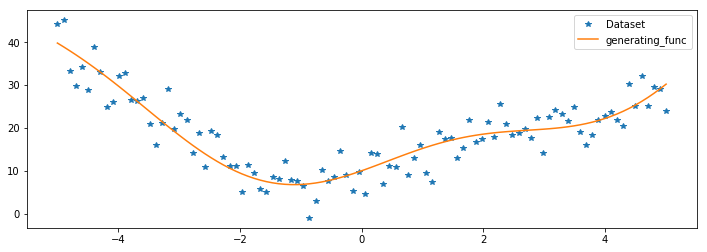

In [6]:
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# initialise Networks

In [7]:
from estimators import GaussianLossEstimator,GaussianLearningRateEstimator, EnsembleNetwork

gauss = GaussianLossEstimator(**params)
gauss_lr = GaussianLearningRateEstimator(**params)
vanilla = EnsembleNetwork(**params)

In [8]:
gauss_preds = gauss.predict(X)
gauss_var = gauss.predict_var(X)


lr_preds = gauss_lr.predict(X)
lr_var = gauss_lr.predict_var(X)

vanilla_preds = vanilla.predict(X)

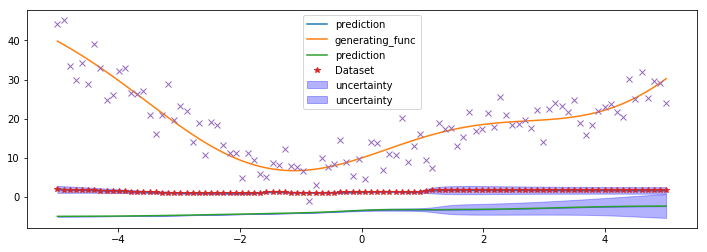

In [9]:
plot_prediction(X,
                gauss_preds,
                sorted_index,
                gauss_var,
                generating_func=generate_sinoid)
plot_prediction(X,
                lr_preds,
                sorted_index,
                lr_var)
plot_prediction(X,vanilla_preds,sorted_index)
plt.plot(X,y,'x')

In [10]:
evaluate_model(X,y,gauss_preds)

RSME is 19.211289052365117


In [11]:
evaluate_model(X,y,lr_preds)

RSME is 23.96903549500662


In [12]:
evaluate_model(X,y,vanilla_preds)

RSME is 19.211289052365117


# Training


## GaussianLossEstimator

Maye replace min_variance with 

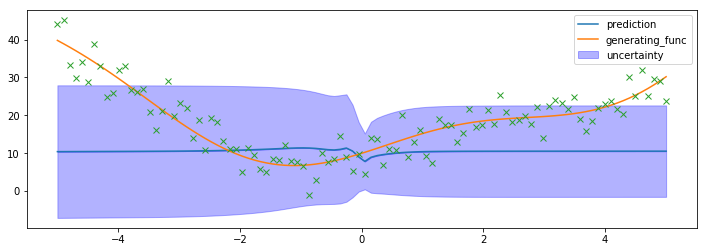

RSME is 12.093163779119616
COVERAGE PROBABILITY is 0.76
MEAN VARIANCE is 14.077203750610352
COVERAGE/MEAN_VAR is 0.05398799459495273


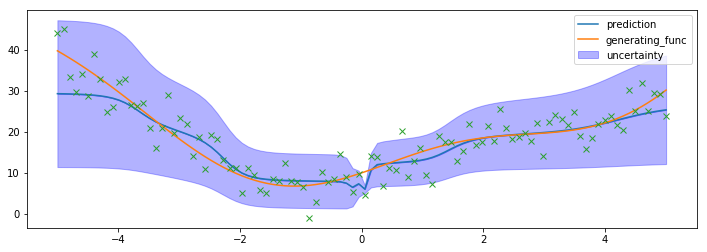

RSME is 4.184776883420187
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.675573348999023
COVERAGE/MEAN_VAR is 0.098185395917471


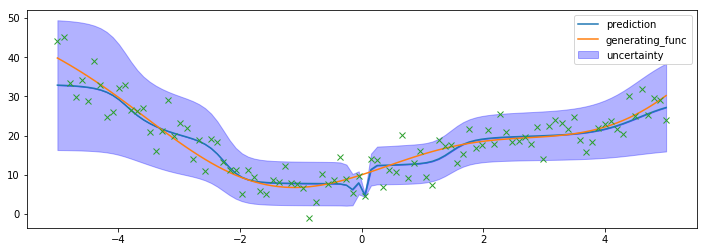

RSME is 3.8113239795534017
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 7.880193710327148
COVERAGE/MEAN_VAR is 0.12055541207762524


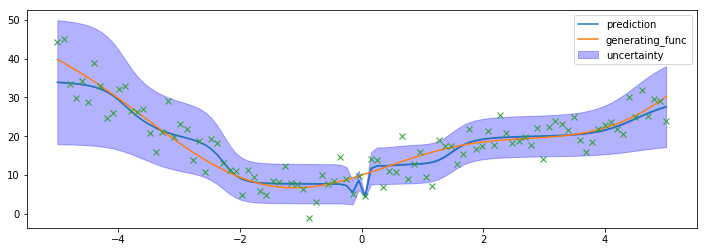

RSME is 3.7388531695133755
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 7.166198253631592
COVERAGE/MEAN_VAR is 0.128380483966345


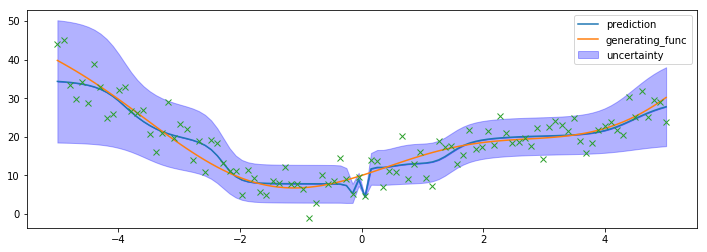

RSME is 3.708246343383756
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 6.855136871337891
COVERAGE/MEAN_VAR is 0.13420592721446964


In [13]:
for i in range(100):
    gauss.train(X,y)
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%20 ==0:
        gauss_preds = gauss.predict(X)
        gauss_var = gauss.predict_var(X)

        #lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds,var=gauss_var)

## GaussianLearningRateEstimator

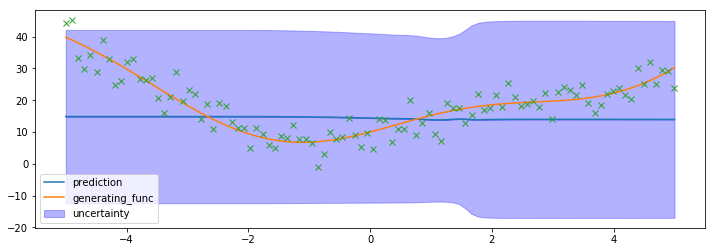

RSME is 9.935658165343913
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 28.279399871826172
COVERAGE/MEAN_VAR is 0.034654200741237845


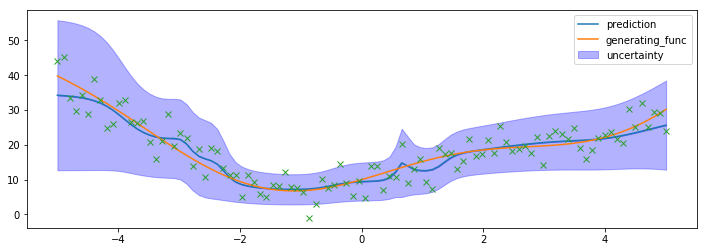

RSME is 3.7524234299717394
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.212915420532227
COVERAGE/MEAN_VAR is 0.1042015427451456


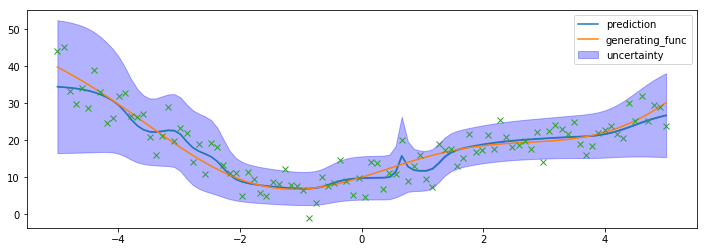

RSME is 3.6548698136345505
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 7.743329048156738
COVERAGE/MEAN_VAR is 0.12397768376232485


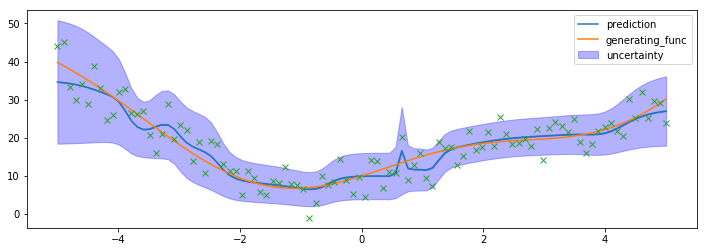

RSME is 3.6414804991779066
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 7.08432674407959
COVERAGE/MEAN_VAR is 0.13551040694195496


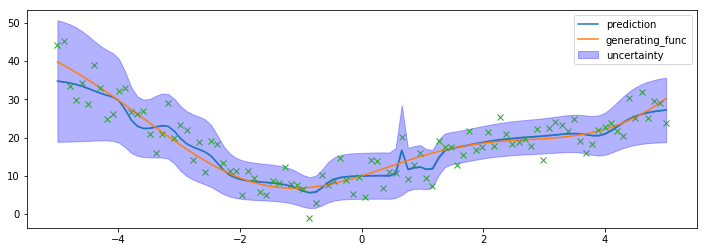

RSME is 3.561113859247485
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 6.764796257019043
COVERAGE/MEAN_VAR is 0.141911147583184


In [14]:
for i in range(100):
    gauss_lr.train(X,y)
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%20 ==0:
        gauss_preds = gauss_lr.predict(X)
        gauss_var = gauss_lr.predict_var(X)

        #3lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds,var=gauss_var)

## Vanilla Neural Network for comparisson

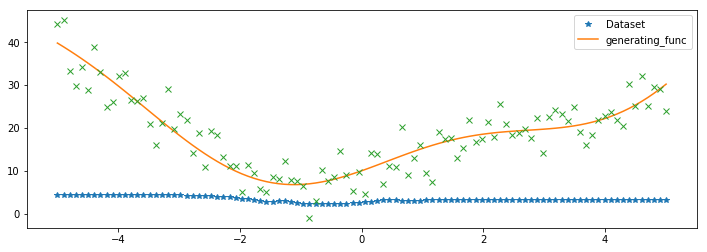

RSME is 17.450921727797887


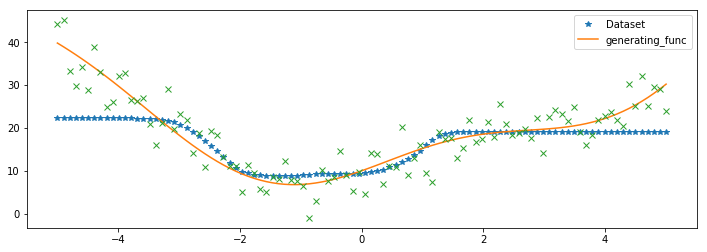

RSME is 6.088815560047585


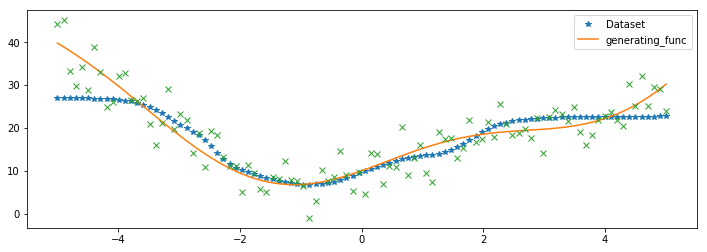

RSME is 4.714369358890215


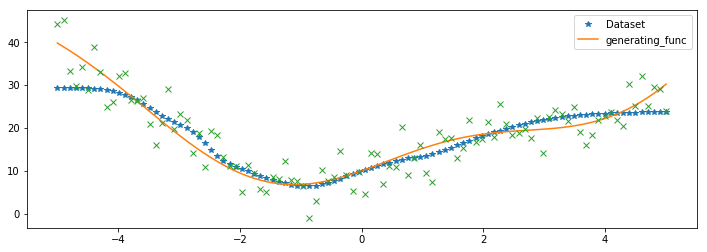

RSME is 4.303801118564077


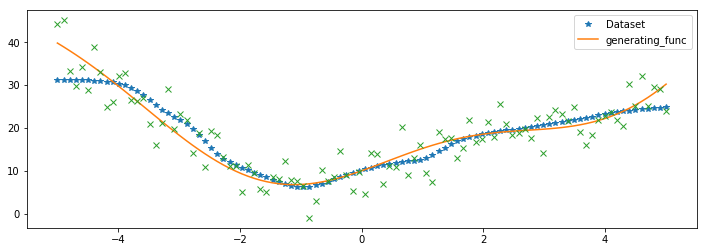

RSME is 4.079910762055555


In [15]:
for i in range(100):
    vanilla.train(X,y)
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%20 ==0:
        gauss_preds = vanilla.predict(X)
        #gauss_var = vanilla.predict_var(X)

        #3lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds)

In [16]:
gauss.train(X,y)
gauss_lr.train(X,y)
vanilla.train(X,y)

In [17]:
gauss_preds = gauss.predict(X)
gauss_var = gauss.predict_var(X)

lr_preds = gauss_lr.predict(X)
lr_var = gauss_lr.predict_var(X)

vanilla_preds = vanilla.predict(X)

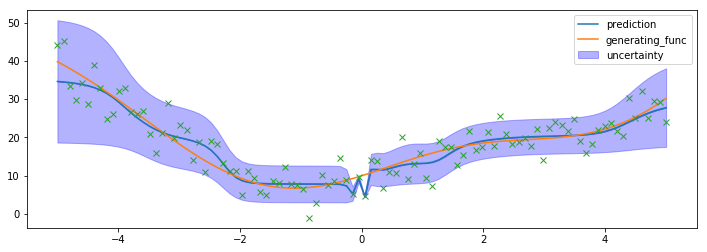

In [18]:
plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
plt.plot(X,y,'x')

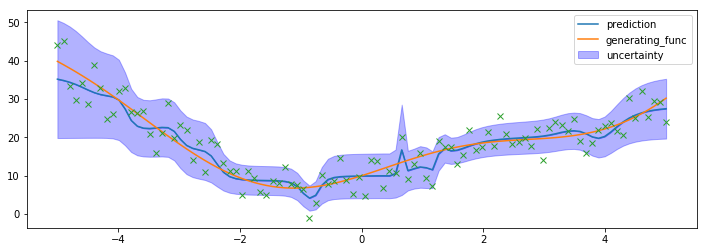

In [19]:
plot_prediction(X,lr_preds,sorted_index,lr_var,generating_func=generate_sinoid)
plt.plot(X,y,'x')

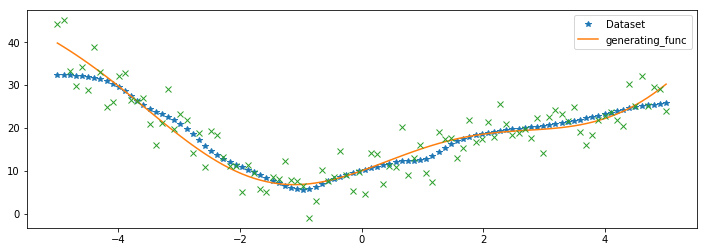

In [20]:
plot_prediction(X,vanilla_preds,sorted_index,generating_func=generate_sinoid)
plt.plot(X,y,'x')

In [21]:
evaluate_model(X,y,gauss_preds,var=gauss_var)

RSME is 3.686103651705829
COVERAGE PROBABILITY is 0.89
MEAN VARIANCE is 6.6541361808776855
COVERAGE/MEAN_VAR is 0.13375139549407425


In [22]:
evaluate_model(X,y,lr_preds,var=lr_var)

RSME is 3.496034732650764
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 6.204504013061523
COVERAGE/MEAN_VAR is 0.1482793786680201


In [23]:
evaluate_model(X,y,vanilla_preds)

RSME is 3.89298195176206
